In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
from sklearn.decomposition import PCA

### Loading XGB
import xgboost as xgb

# Clustering
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.mixture import GaussianMixture

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import Row
from bokeh import palettes

/opt/conda/lib/python3.6/site-packages/bokeh/core/json_encoder.py:52: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  NP_EPOCH = np.datetime64('1970-01-01T00:00:00Z')


In [2]:
output_notebook()

Loading BokehJS ...

## Loading data

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
cat_cols = []
for c in train.columns:
    if train[c].dtype == 'object':
        cat_cols.append(c)
print('Categorical columns:', cat_cols)

d = {}; done = []
cols = train.columns.values
for c in cols: d[c]=[]
for i in range(len(cols)):
    if i not in done:
        for j in range(i+1, len(cols)):
            if all(train[cols[i]] == train[cols[j]]):
                done.append(j)
                d[cols[i]].append(cols[j])
            
dub_cols = []
for k in d.keys():
    if len(d[k]) > 0: 
        dub_cols += d[k]        
print('Dublicates:', dub_cols)

const_cols = []
for c in cols:
    if len(train[c].unique()) == 1:
        const_cols.append(c)
print('Constant cols:', const_cols)

Categorical columns: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
Dublicates: ['X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347', 'X382', 'X232', 'X279', 'X35', 'X37', 'X39', 'X302', 'X113', 'X134', 'X147', 'X222', 'X102', 'X214', 'X239', 'X76', 'X324', 'X248', 'X253', 'X385', 'X172', 'X216', 'X213', 'X84', 'X244', 'X122', 'X243', 'X320', 'X245', 'X94', 'X242', 'X199', 'X119', 'X227', 'X146', 'X226', 'X326', 'X360', 'X262', 'X266', 'X247', 'X254', 'X364', 'X365', 'X296', 'X299']
Constant cols: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


In [5]:
train['set'] = 0; test['set'] = 1
df = pd.concat([train, test], axis=0, copy=True)
df.reset_index(drop=True, inplace=True)

## Categoriacal encoding

In [6]:
def build_funcs(col_name):
    assert col_name in cat_cols
    new_col = train.groupby(col_name).y.mean().sort_values().reset_index().reset_index().set_index(col_name).drop('y', axis=1)
    new_col.columns = ['nums']
    new_col = new_col.nums.to_dict()
    def add_new_col(x):
        if x not in new_col.keys(): return int(len(new_col.keys())/2)
        return new_col[x]
    return add_new_col

for c in cat_cols:
    f_new_col  = build_funcs(c)
    df[c + '_new'] = df[c].apply(f_new_col)

## Dummies

In [7]:
list_of_dummies = []
for col in cat_cols:
    dum_col = pd.get_dummies(df[col], prefix=col)
    list_of_dummies.append(dum_col)
X_dum = pd.concat(list_of_dummies, axis=1, copy=True)

## X

In [8]:
X = pd.concat([df, X_dum], axis=1, copy=True)
X = X.drop(list((set(const_cols) | set(dub_cols) | set(cat_cols))), axis=1)
n_tr = len(train)

## PCA and t-SNE

In [9]:
%%time
n_comp = 200
pca = PCA(n_components=n_comp, random_state=420)
rep = pca.fit_transform(X.drop(['y', 'set', 'ID'], axis=1))

tsne = TSNE(perplexity=100, learning_rate=1000, early_exaggeration=18.0, n_iter=5000, random_state=0, metric='canberra')
tsne_representation = tsne.fit_transform(rep) ## cityblock, canberra, hamming, matching, jaccard

CPU times: user 2min 47s, sys: 1min 5s, total: 3min 52s
Wall time: 3min 24s


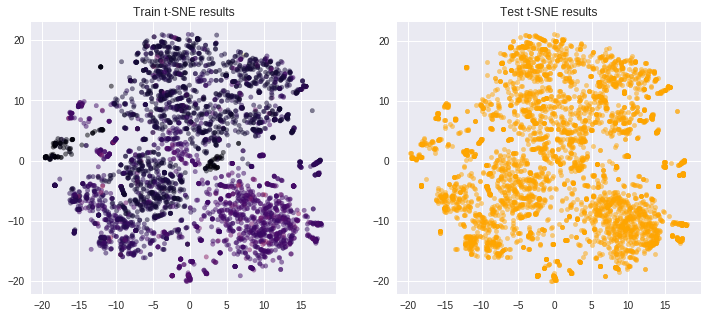

In [10]:
plt.figure(figsize=(12,5))
cmap = plt.cm.get_cmap('inferno')
plt.subplot(1,2,1)
plt.title('Train t-SNE results')
plt.scatter(tsne_representation[:n_tr,0], tsne_representation[:n_tr,1], alpha=0.5, c=df.y[:n_tr], cmap=cmap, s=20)
plt.subplot(1,2,2)
plt.title('Test t-SNE results')
plt.scatter(tsne_representation[n_tr:,0], tsne_representation[n_tr:,1], alpha=0.5, c='orange', s=20)

In [11]:
pal = palettes.all_palettes['Viridis'][4]

colors = []
for x in train.y.values:
    if x < 85: colors.append(pal[0])
    if (x >= 85) and (x < 135): colors.append(pal[1])
    if (x >= 135) and (x < 200): colors.append(pal[2])
    if (x >= 200): colors.append(pal[3])
    

source_train = ColumnDataSource(
        data=dict(
            x = tsne_representation[:n_tr,0],
            y = tsne_representation[:n_tr,1],
            desc = train.y[:n_tr],
            colors = colors
        )
    )

source_test = ColumnDataSource(
        data=dict(
            x = tsne_representation[n_tr:,0],
            y = tsne_representation[n_tr:,1]
        )
    )

hover_tsne = HoverTool(names=["train"], tooltips=[("Y", "@desc")])
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']

plot_tsne = figure(plot_width=400, plot_height=400, tools=tools_tsne, title='Train t-SNE')
plot_tsne.circle('x', 'y', size=5, fill_color='colors', alpha=0.5, line_width=0, source=source_train, name="train")

plot_tsne_test = figure(plot_width=400, plot_height=400, tools=['pan', 'wheel_zoom', 'reset'], title='Test t-SNE')
plot_tsne_test.square('x', 'y', size=3, fill_color='orange', alpha=0.9, line_width=0, source=source_test, name="test")

r = Row(children=[plot_tsne, plot_tsne_test])

show(r)

In [12]:
# function to show plots nicely
def show_plots(labels):
    plt.figure(figsize=(18,3))

    plt.subplot(1,6,1)
    plt.title('t-SNE clusters')
    colors = [['r', 'g', 'b'][i] for i in labels]
    plt.scatter(x=tsne_representation[:n_tr,0], y=tsne_representation[:n_tr,1], c=colors, alpha=0.7, s=20)

    plt.subplot(1,6,2); plt.ylim(0,850); plt.xlim(0,270); plt.title('Cluster 0')
    plt.hist(train[labels == 0].y, bins=50, alpha=0.5, color='r')[2]

    plt.subplot(1,6,3); plt.ylim(0,850); plt.xlim(0,270); plt.title('Cluster 1')
    plt.hist(train[labels == 1].y, bins=50, alpha=0.5, color='g')[2]

    plt.subplot(1,6,4); plt.ylim(0,850); plt.xlim(0,270); plt.title('Cluster 2')
    plt.hist(train[labels == 2].y, bins=50, alpha=0.5, color='b')[2]

    plt.subplot(1,6,5); plt.ylim(0,850); plt.xlim(0,270); plt.title('All together')
    plt.hist(train[labels == 0].y, bins=50, alpha=0.5, color='r')[2]
    plt.hist(train[labels == 1].y, bins=50, alpha=0.5, color='g')[2]
    plt.hist(train[labels == 2].y, bins=50, alpha=0.5, color='b')[2]

    plt.subplot(1,6,6); plt.ylim(0,850); plt.xlim(0,270); plt.title('Train y')
    plt.hist(train.y, bins=50, alpha=0.3, color='c')[2]
    
    plt.show()

## Clusters (on train)

Mini Batch K-Means:


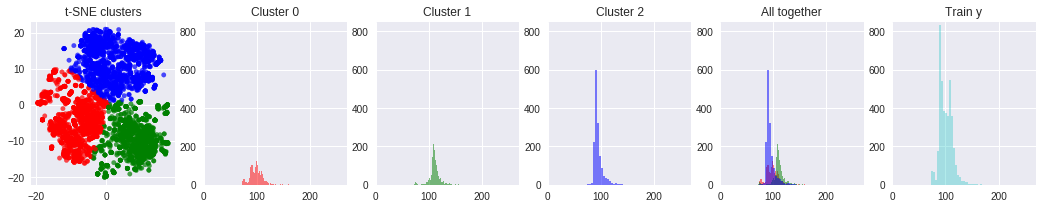

Agglomerative Clustering:


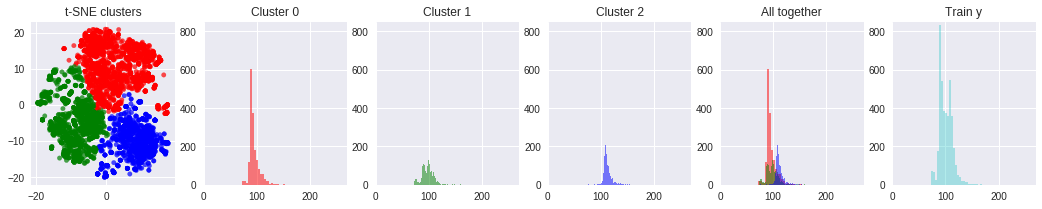

Birch:


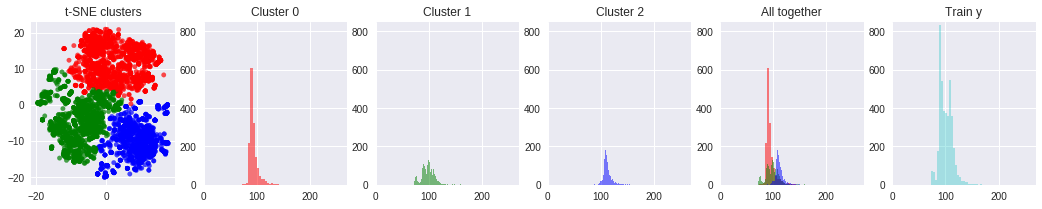

Gaussian Mixture:


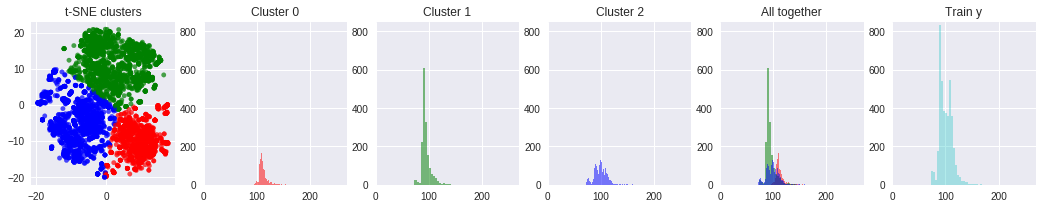

In [13]:
# MiniBatchKMeans
min_bat = cluster.MiniBatchKMeans(n_clusters=3, random_state=42)
min_bat.fit(tsne_representation[:n_tr])
labels = min_bat.predict(tsne_representation[:n_tr])
print('Mini Batch K-Means:')
show_plots(labels)

# AgglomerativeClustering
agl_cl = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean')
labels = agl_cl.fit_predict(tsne_representation[:n_tr])
print('Agglomerative Clustering:')
show_plots(labels)

# Birch
bir = cluster.Birch(n_clusters=3, branching_factor=25)
labels = bir.fit_predict(tsne_representation[:n_tr])
print('Birch:')
show_plots(labels)

# GaussianMixture
gaus = GaussianMixture(n_components=3, random_state=0)
gaus.fit(tsne_representation[:n_tr])
labels = gaus.predict((tsne_representation[:n_tr]))
print('Gaussian Mixture:')
show_plots(labels)